<a href="https://colab.research.google.com/github/peterszklenar/course-v3/blob/master/Covid_19_Excess_Death.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn
!pip install fastai

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn import preprocessing 
from fastai import *

In [ ]:
#procs = [Categorify, FillMissing]

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# due to uni-code compatibility issues file could not be read directly from github 
country_daily_excess_deaths = pd.read_csv('/gdrive/My Drive/Covid-19/data_with_sero_ifr_econ_pol.csv', low_memory=False)
country_daily_excess_deaths.shape

(72549, 156)

In [ ]:
# How many countries and how many variables?
len(country_daily_excess_deaths['country.x'].unique()), len(country_daily_excess_deaths.columns)

(202, 156)

In [ ]:
country_daily_excess_deaths.head()

,iso3c,date,country.x,country_code,region,subregion,population,gdp_per_capita,human_development_index,v2x_libdem,v2x_freexp_altinf,median_age,aged_70_older,life_expectancy,stringency_index,daily_covid_deaths,daily_covid_deaths_per_100k,daily_covid_cases,daily_covid_cases_per_100k,daily_tests,daily_tests_per_100k,daily_positive_rate,daily_total_deaths,daily_total_deaths_per_100k,daily_expected_deaths,daily_expected_deaths_per_100k,daily_excess_deaths,daily_excess_deaths_per_100k,country.y,ccode.x,abbreviation,abbreviation_undp,year.x,democracy,democracy_trans,democracy_breakdowns,democracy_duration,democracy_omitteddata,democracy_femalesuffrage,Country/Territory,...,change,d5,sf,regtrans,V1,area,area_ifr,iso2c,country.name,econ_section,econ_sub_section,pop.2020,pop.adult,pop.60plus,cases,new_cases,new_cases_7dma,cases.100k.pop,new.cases.100k.pop,deaths,new_deaths,new_deaths_7dma,deaths.100k.pop,new.deaths.100k.pop,cfr,total.vaccinations,first.dose,second.dose,first.dose.pct,second.dose.pct,vaccinations.perday.100k.pop,log_gdp_ppp,case_ir,death_r,pred_ir,pred_ir_low,pred_ir_high,pred_cases,pred_cases_low,pred_cases_high
0,AFG,3/1/2020,Afghanistan,AFG,Asia,Southern Asia,38928341,1803.987,0.511,0.212,0.614,18.6,1.337,64.83,27.78,0.0,0.0,0.143,0.000367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFGHANISTAN,700.0,AFG,AFG,2015.0,0.0,0.0,0.0,216.0,0.0,0.0,Afghanistan,...,NaN,NaN,NaN,NaN,82.0,Afghanistan,0.133978,AF,Afghanistan,Asia,Central Asia,38928341.0,18018050.0,1643876.0,1.0,0.0,NaN,0.002569,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-13.162522,2.570000e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AFG,3/2/2020,Afghanistan,AFG,Asia,Southern Asia,38928341,1803.987,0.511,0.212,0.614,18.6,1.337,64.83,27.78,0.0,0.0,0.000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFGHANISTAN,700.0,AFG,AFG,2015.0,0.0,0.0,0.0,216.0,0.0,0.0,Afghanistan,...,NaN,NaN,NaN,NaN,82.0,Afghanistan,0.133978,AF,Afghanistan,Asia,Central Asia,38928341.0,18018050.0,1643876.0,1.0,0.0,0.000000,0.002569,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-13.162522,2.570000e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AFG,3/3/2020,Afghanistan,AFG,Asia,Southern Asia,38928341,1803.987,0.511,0.212,0.614,18.6,1.337,64.83,27.78,0.0,0.0,0.143,0.000367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFGHANISTAN,700.0,AFG,AFG,2015.0,0.0,0.0,0.0,216.0,0.0,0.0,Afghanistan,...,NaN,NaN,NaN,NaN,82.0,Afghanistan,0.133978,AF,Afghanistan,Asia,Central Asia,38928341.0,18018050.0,1643876.0,2.0,1.0,0.142857,0.005138,0.000367,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-13.162522,5.140000e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AFG,3/4/2020,Afghanistan,AFG,Asia,Southern Asia,38928341,1803.987,0.511,0.212,0.614,18.6,1.337,64.83,27.78,0.0,0.0,0.429,0.001102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFGHANISTAN,700.0,AFG,AFG,2015.0,0.0,0.0,0.0,216.0,0.0,0.0,Afghanistan,...,NaN,NaN,NaN,NaN,82.0,Afghanistan,0.133978,AF,Afghanistan,Asia,Central Asia,38928341.0,18018050.0,1643876.0,4.0,2.0,0.428571,0.010275,0.001101,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-13.162522,1.030000e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AFG,3/5/2020,Afghanistan,AFG,Asia,Southern Asia,38928341,1803.987,0.511,0.212,0.614,18.6,1.337,64.83,27.78,0.0,0.0,0.429,0.001102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFGHANISTAN,700.0,AFG,AFG,2015.0,0.0,0.0,0.0,216.0,0.0,0.0,Afghanistan,...,NaN,NaN,NaN,NaN,82.0,Afghanistan,0.133978,AF,Afghanistan,Asia,Central Asia,38928341.0,18018050.0,1643876.0,4.0,0.0,0.428571,0.010275,0.001101,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-13.162522,1.030000e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0


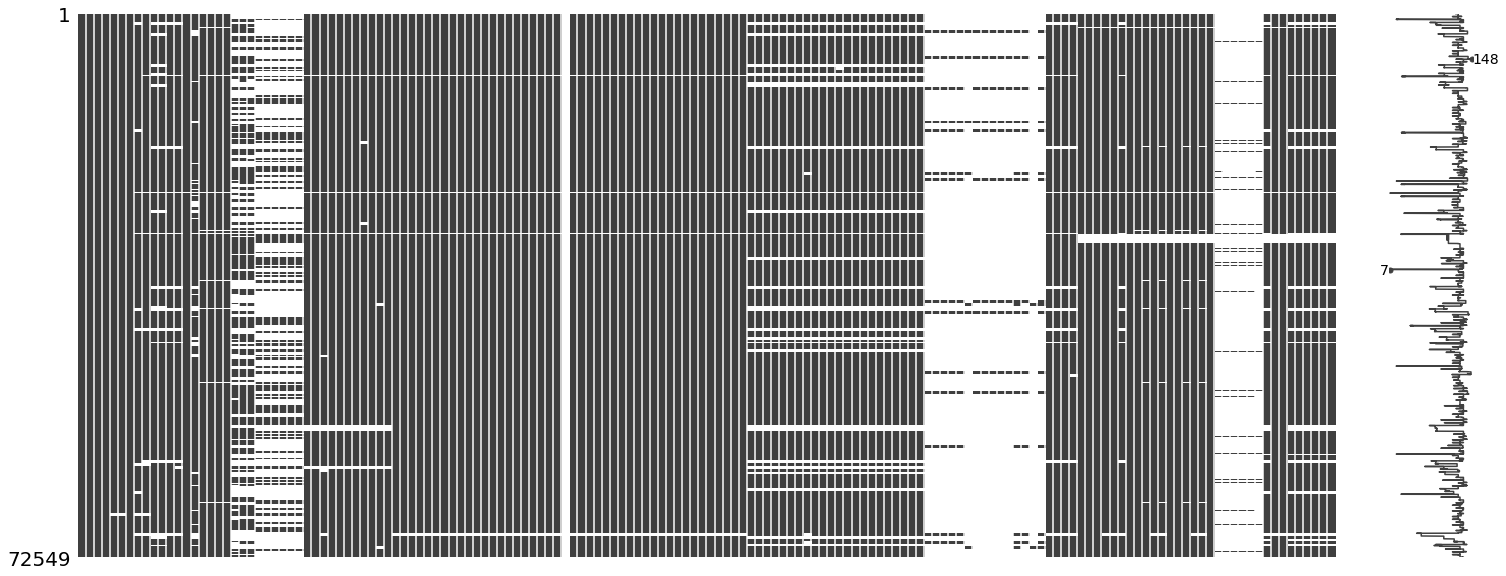

In [ ]:
msno.matrix(country_daily_excess_deaths)

In [ ]:
# see the relative number of NaN values by variables
isna = country_daily_excess_deaths.isna().sum().sort_values(ascending=False)/country_daily_excess_deaths.shape[0]*100

isna = country_daily_excess_deaths.isna().sum()
isna[isna>0].sort_values(ascending=False)/country_daily_excess_deaths.shape[0]*100

In [ ]:
# select variables to drop where the ratio of missing values is above 90%
drop_vars = isna[isna>90].sort_values(ascending=False)
len(drop_vars), drop_vars

In [ ]:
country_daily_excess_deaths.drop(columns=drop_vars.index, inplace=True)

In [ ]:
# drop vars with redundancy regarding democracy scores, keeping only PR (Political rights), CL (Civil Liberty) and Total (PR+CL):
drop_dem_vars = ['A1','A2',	'A3','A','B1','B2',	'B3',	'B4',	'B',	'C1',	'C2',	'C3',	'C', 'Add Q', 'D1','D2',	'D3',	'D4',	'D','E1',	'E2',	'E3','E',	'F1',	'F2',	'F3',	'F4',	'F','G1',	'G2',	'G3',	'G4',	'G']
len(drop_dem_vars), country_daily_excess_deaths.drop(columns=drop_dem_vars, inplace=True)

(33, None)

In [ ]:
# it is visible that covid cases, covid deaths and total and excess death are the ones with a lot of missing values stull:
# for covid cases and covid deaths the new_cases and new_deaths is available: these variables are interchangable so we can make it equall.
# Excess deaths can be imported from other Economist table (Excess death tracker)
# Check consistency in important redundant cariables
country_daily_excess_deaths.isna().groupby(country_daily_excess_deaths['iso3c']).sum()[['new_cases_7dma', "daily_covid_cases", 'new_deaths_7dma', 'daily_covid_deaths']].sum()

new_cases_7dma        2430
daily_covid_cases     1535
new_deaths_7dma       2430
daily_covid_deaths    1535
dtype: int64

In [ ]:
country_daily_excess_deaths.groupby('iso3c').count().sum()[['new_cases_7dma', "daily_covid_cases", 'new_deaths_7dma', 'daily_covid_deaths']]

new_cases_7dma        70119
daily_covid_cases     71014
new_deaths_7dma       70119
daily_covid_deaths    71014
dtype: int64

In [ ]:
# Mutually fill the NaN values whereever the other is missing. This make them  equivalent in terms of data, thus of them from the pair is redundant variables
country_daily_excess_deaths['new_cases_7dma'].fillna(country_daily_excess_deaths['daily_covid_cases'],inplace=True)
country_daily_excess_deaths['daily_covid_cases'].fillna(country_daily_excess_deaths['new_cases_7dma'],inplace=True)

country_daily_excess_deaths['new_deaths_7dma'].fillna(country_daily_excess_deaths['daily_covid_deaths'],inplace=True)
country_daily_excess_deaths['daily_covid_deaths'].fillna(country_daily_excess_deaths['new_deaths_7dma'],inplace=True)

country_daily_excess_deaths.isna().groupby(country_daily_excess_deaths['iso3c']).sum()[['new_cases_7dma', "daily_covid_cases", 'new_deaths_7dma', 'daily_covid_deaths']].sum()

new_cases_7dma        893
daily_covid_cases     893
new_deaths_7dma       893
daily_covid_deaths    893
dtype: int64

In [ ]:
country_daily_excess_deaths.groupby('iso3c').count().sum()[['new_cases_7dma', "daily_covid_cases", 'new_deaths_7dma', 'daily_covid_deaths']]

new_cases_7dma        71656
daily_covid_cases     71656
new_deaths_7dma       71656
daily_covid_deaths    71656
dtype: int64

In [ ]:
# Ensure consistency among variables
country_daily_excess_deaths['daily_covid_cases_per_100k'] = country_daily_excess_deaths['daily_covid_cases']/country_daily_excess_deaths['population']*100000
country_daily_excess_deaths['daily_covid_deaths_per_100k'] = country_daily_excess_deaths['daily_covid_deaths']/country_daily_excess_deaths['population']*100000

In [ ]:
# Ensure consistency among variables
country_daily_excess_deaths['daily_total_deaths'] = country_daily_excess_deaths['daily_expected_deaths'].add(country_daily_excess_deaths['daily_excess_deaths'])

country_daily_excess_deaths['daily_total_deaths_per_100k'] = country_daily_excess_deaths['daily_total_deaths']/country_daily_excess_deaths['population']*100000
country_daily_excess_deaths['daily_expected_deaths_per_100k'] = country_daily_excess_deaths['daily_expected_deaths']/country_daily_excess_deaths['population']*100000
country_daily_excess_deaths['daily_excess_deaths_per_100k'] = country_daily_excess_deaths['daily_excess_deaths']/country_daily_excess_deaths['population']*100000

In [ ]:
# delete redundant variables:
country_daily_excess_deaths.drop(columns=['new_cases_7dma', 'new_deaths_7dma','new.cases.100k.pop','new.deaths.100k.pop'], inplace=True)

# Checking NaN distributions by countries and variables

In [ ]:
# Sort variables by total number of NaN values
group_by_country = country_daily_excess_deaths.groupby('iso3c').count()
divider = group_by_country['date']
for c in group_by_country.columns:
  group_by_country[c] = group_by_country[c]/divider
# sort columns (variables) by ratio of  missing values
cols = (group_by_country.sum()/group_by_country.shape[0]).sort_values().index
group_by_country = group_by_country[cols]

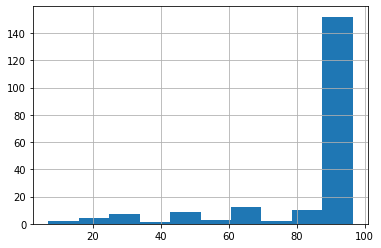

In [ ]:
# check the distribution of non-NaN values by countries
group_by_country.sum(1).hist()

In [ ]:
# Sort countries by total number of NaN values
countries_sorted = group_by_country.sum(1).sort_values(ascending=False).index
sorterIndex = dict(zip(countries_sorted, range(len(countries_sorted))))
country_daily_excess_deaths['country_rank_by_NaNs'] = country_daily_excess_deaths['iso3c'].map(sorterIndex)
country_daily_excess_deaths.sort_values(['country_rank_by_NaNs'], ascending=True ,inplace=True)

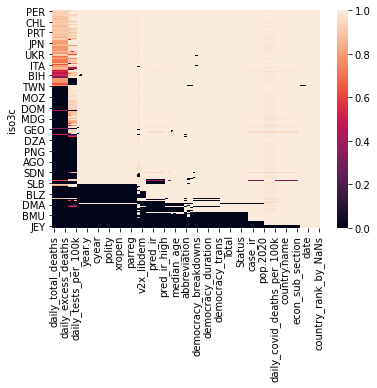

In [ ]:
# checking NaN values by country and variables
sns.heatmap(group_by_country.reindex(sorterIndex))

In [ ]:
# list of death related variables:
death_variables = ['daily_covid_cases', 'daily_covid_cases_per_100k',
                   'daily_covid_deaths', 'daily_covid_deaths_per_100k',
                   'daily_expected_deaths', 'daily_expected_deaths_per_100k',
                   'daily_excess_deaths', 'daily_excess_deaths_per_100k',
                   'daily_total_deaths', 'daily_total_deaths_per_100k']

In [ ]:
group_by_country.reindex(sorterIndex).mean()

daily_total_deaths                0.304336
daily_total_deaths_per_100k       0.304336
daily_expected_deaths             0.304336
daily_expected_deaths_per_100k    0.304336
daily_excess_deaths               0.304336
                                    ...   
date                              1.000000
country_code                      1.000000
country.x                         1.000000
population                        1.000000
country_rank_by_NaNs              1.000000
Length: 97, dtype: float64

In [ ]:
# listing those countries where Covid cases and deaths data are fully available
group_by_country.reindex(sorterIndex).iloc[:(group_by_country[['daily_covid_cases', 'daily_covid_cases_per_100k',
                                                               'daily_covid_deaths', 'daily_covid_deaths_per_100k']].mean(1)==1).sum()].index

Index(['PER', 'DNK', 'CHE', 'NOR', 'NLD', 'CYP', 'USA', 'BEL', 'ISR', 'NZL',
       'CHL', 'THA', 'ZAF', 'LTU', 'FIN', 'EST', 'LVA', 'ESP', 'RUS', 'AUT',
       'PRT', 'GBR', 'KAZ', 'BGR', 'QAT', 'HUN', 'POL', 'TUN', 'KOR', 'MEX',
       'JPN', 'LUX', 'SVN', 'FRA', 'SVK', 'PRY', 'PAN', 'ROU', 'ECU', 'SGP',
       'UKR', 'SWE', 'DEU', 'MYS', 'GRC', 'COL', 'JAM', 'PHL', 'AUS', 'OMN',
       'ITA', 'HRV', 'MKD'],
      dtype='object', name='iso3c')

In [ ]:
# listing those countries where expected and excess deathsare mainly available
group_by_country.reindex(sorterIndex).iloc[:(group_by_country[['daily_expected_deaths', 'daily_expected_deaths_per_100k',
                                                               'daily_excess_deaths', 'daily_excess_deaths_per_100k']].mean(1)>=0.80).sum()].index

Index(['PER', 'DNK', 'CHE', 'NOR', 'NLD', 'CYP', 'USA', 'BEL', 'ISR', 'NZL',
       'CHL', 'THA', 'ZAF', 'LTU', 'FIN', 'EST', 'LVA', 'ESP', 'RUS', 'AUT',
       'PRT', 'GBR', 'KAZ', 'BGR', 'QAT', 'HUN', 'POL', 'TUN', 'KOR', 'MEX',
       'JPN', 'LUX', 'SVN', 'FRA', 'SVK', 'PRY', 'PAN', 'ROU', 'ECU', 'SGP',
       'UKR', 'SWE', 'DEU', 'MYS'],
      dtype='object', name='iso3c')

# Separating numerical and categorical variables

In [ ]:
# Select numerical values for seprating 'static data' from variables from 'time-variant' data, for separate handling NaN values
country_daily_excess_deaths_num = country_daily_excess_deaths.select_dtypes(include=['float64', 'int'])
country_daily_excess_deaths_cat = country_daily_excess_deaths.select_dtypes(exclude=['float64', 'int'])
# add iso3c variable for categorization of numeric variables per countires
country_daily_excess_deaths_num["iso3c"]=country_daily_excess_deaths['iso3c']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# Check the ratio of NaN values by country and by numerical variables
group_by_country_num = country_daily_excess_deaths_num.groupby('iso3c').count()
divider = group_by_country_num['population']
for c in group_by_country_num.columns:
  group_by_country_num[c] = group_by_country_num[c]/divider
# sort countries by total number of NaN values
countries_sorted_num = group_by_country_num.sum(1).sort_values(ascending=False).index
sorterIndex = dict(zip(countries_sorted_num, range(len(countries_sorted_num))))
country_daily_excess_deaths_num['country_rank_by_NaNs'] = country_daily_excess_deaths_num['iso3c'].map(sorterIndex)
country_daily_excess_deaths_num.sort_values(['country_rank_by_NaNs'], ascending=True ,inplace=True)
# sort columns (variables) by ratio of  missing values
cols_num = (group_by_country_num.sum()/group_by_country_num.shape[0]).sort_values().index
group_by_country_num = group_by_country_num[cols_num]
group_by_country_num.reindex(sorterIndex)

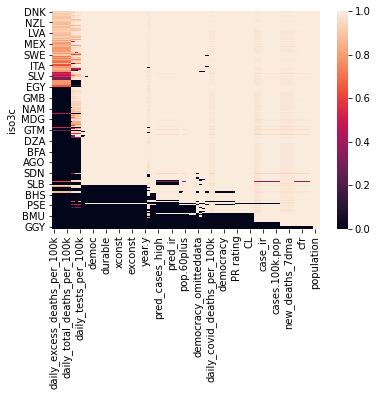

In [ ]:
sns.heatmap(group_by_country_num.reindex(sorterIndex))

In [ ]:
country_daily_excess_deaths_num.groupby('iso3c').count().sum().sum()

5231486

In [ ]:
group_by_country_num.mean()

daily_excess_deaths_per_100k      0.304336
daily_excess_deaths               0.304336
daily_expected_deaths_per_100k    0.304336
daily_expected_deaths             0.304336
daily_total_deaths_per_100k       0.304336
                                    ...   
cases                             0.985675
cfr                               0.985675
life_expectancy                   0.990099
population                        1.000000
country_rank_by_NaNs              1.000000
Length: 82, dtype: float64

In [ ]:
# Check the ratio of NaN values by country and by categorical variables
group_by_country_cat = country_daily_excess_deaths_cat.groupby('iso3c').count()
divider= group_by_country_cat['date']
for c in group_by_country_cat.columns:
  group_by_country_cat[c] = group_by_country_cat[c]/divider
# sort columns (variables) by ratio of  missing values
cols_cat = (group_by_country_cat.sum()/group_by_country_cat.shape[0]).sort_values().index
group_by_country_cat = group_by_country_cat[cols_cat]
group_by_country_cat.reindex(sorterIndex)

,country,scode,iso2c,area,abbreviation,country.y,abbreviation_undp,Region,Country/Territory,C/T,Status,country.name,econ_sub_section,econ_section,subregion,region,country_code,country.x,date
iso3c,,,,,,,,,,,,,,,,,,,
DNK,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
PER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CHE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
NOR,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
NLD,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FLK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
SHN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


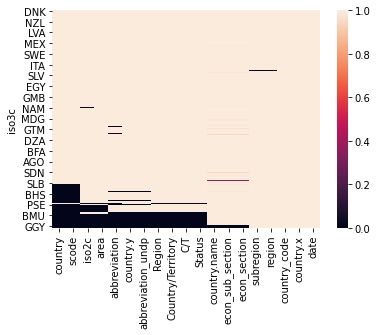

In [ ]:
sns.heatmap(group_by_country_cat.reindex(sorterIndex))

In [ ]:
# select low NaN value countries: overall NaN ratio is >= 75%
group_by_country.sum(1)[group_by_country.sum(1)>=75].sort_values(ascending=False)

iso3c
DNK    99.472585
PER    99.452381
CHE    99.430809
NOR    99.396867
NLD    99.339426
         ...    
SLB    83.620253
SYR    82.853591
IND    81.513568
MLT    76.945170
ISL    76.689295
Length: 164, dtype: float64

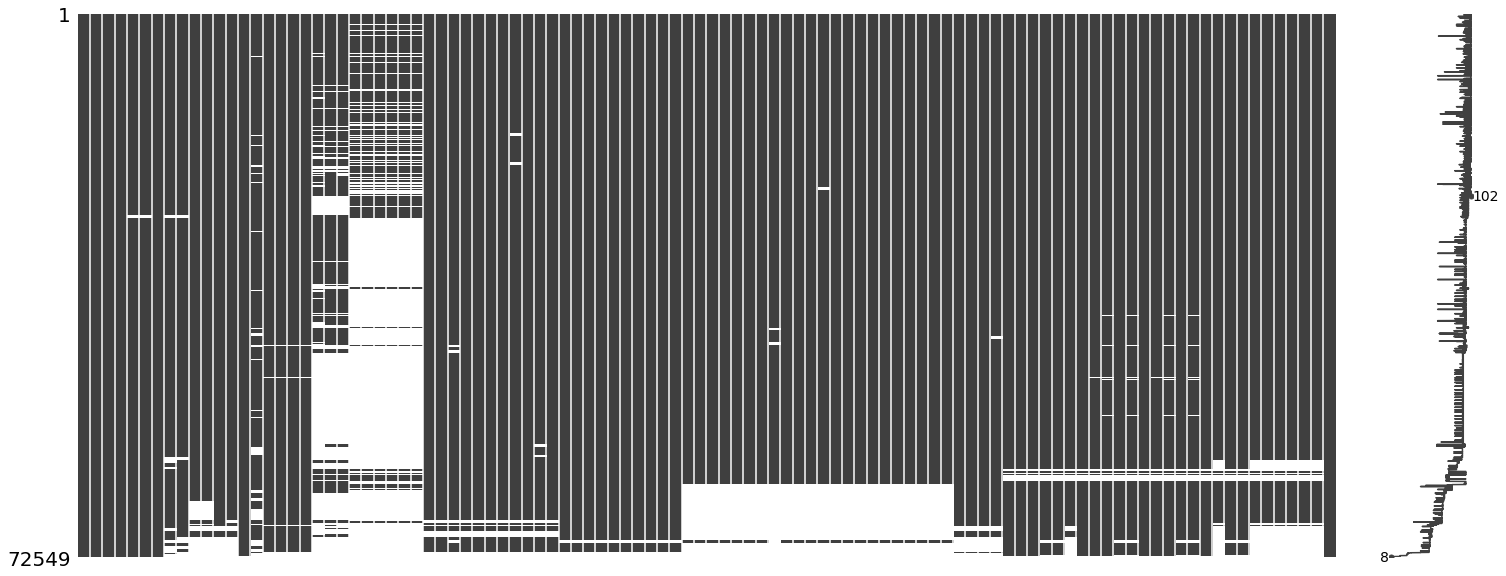

In [ ]:
msno.matrix(country_daily_excess_deaths)

In [ ]:
# Why e.g. INDIA has so many NaN values? Cheking the dates there are redundancies
country_daily_excess_deaths[country_daily_excess_deaths.iso3c=='IND'].date

30383    0024-07-20
30384    0024-07-20
30385    0024-08-20
30386    0024-08-20
30389    0024-09-20
            ...    
31033     8/30/2020
31032     8/29/2020
31031     8/29/2020
31030     8/28/2020
31029     8/28/2020
Name: date, Length: 1990, dtype: object

In [ ]:
# drop dummy dates
country_daily_excess_deaths.drop(country_daily_excess_deaths[(country_daily_excess_deaths.iso3c=='IND')&
                                                                       (country_daily_excess_deaths.date.str.startswith('00'))].index, inplace=True)

In [ ]:
# exclude multiple countries due to Political segmentation by Freedomhouse within the country
country_territories_to_exclude = ['Gaza Strip', 'Indian Kashmir', 'Northern Cyprus','Pakistani Kashmir']

In [ ]:
# drop separate Kashmir regions for India and Pakistan
country_daily_excess_deaths.drop(country_daily_excess_deaths[country_daily_excess_deaths['Country/Territory'].str.contains('Kashmir')==True].index, inplace=True)

In [ ]:
# drop separate Gaza strip for Palestine
country_daily_excess_deaths.drop(country_daily_excess_deaths[country_daily_excess_deaths['Country/Territory'].str.contains('Gaza')==True].index, inplace=True)

In [ ]:
# drop separate Northern Cyprus for Cyprus
country_daily_excess_deaths.drop(country_daily_excess_deaths[country_daily_excess_deaths['Country/Territory'].str.contains('Northern Cyprus')==True].index, inplace=True)

In [ ]:
country_daily_excess_deaths.shape

(69805, 102)

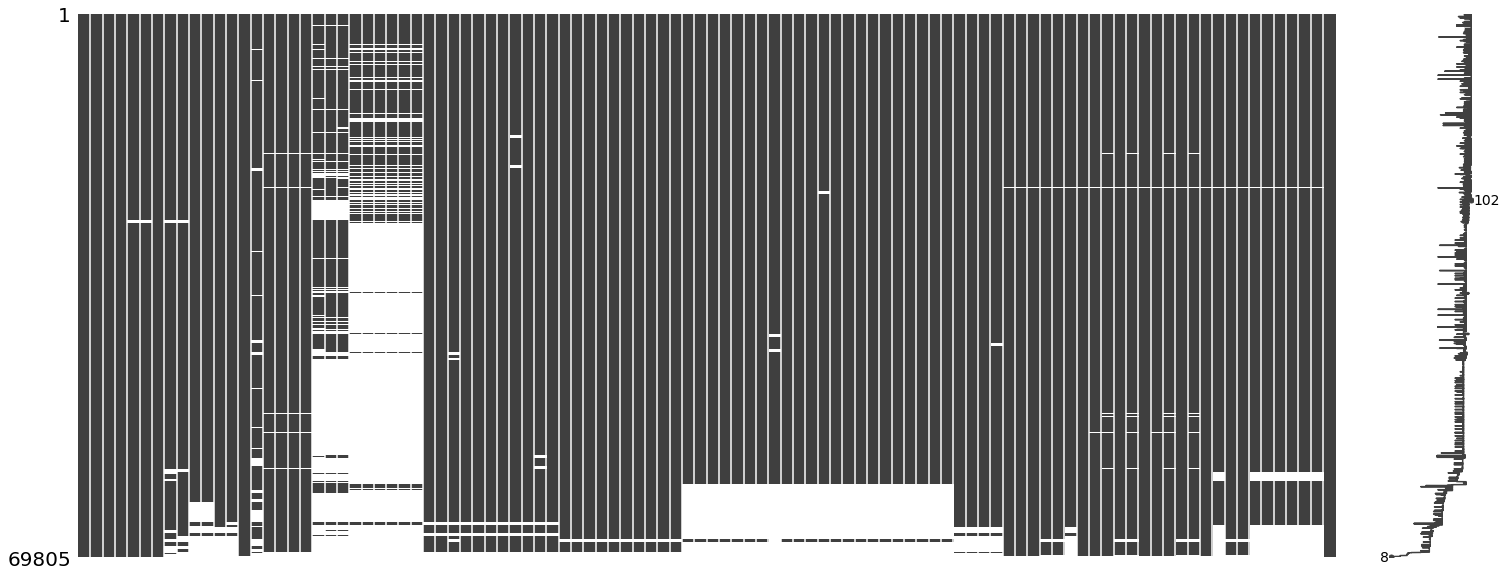

In [ ]:
msno.matrix(country_daily_excess_deaths)

In [ ]:
#country_daily_excess_deaths.drop('country_rank_by_NaNs',1, inplace=True)

In [ ]:
country_daily_excess_deaths

,iso3c,date,country.x,country_code,region,subregion,population,gdp_per_capita,human_development_index,v2x_libdem,v2x_freexp_altinf,median_age,aged_70_older,life_expectancy,stringency_index,daily_covid_deaths,daily_covid_deaths_per_100k,daily_covid_cases,daily_covid_cases_per_100k,daily_tests,daily_tests_per_100k,daily_positive_rate,daily_total_deaths,daily_total_deaths_per_100k,daily_expected_deaths,daily_expected_deaths_per_100k,daily_excess_deaths,daily_excess_deaths_per_100k,country.y,ccode.x,abbreviation,abbreviation_undp,year.x,democracy,democracy_trans,democracy_breakdowns,democracy_duration,democracy_omitteddata,democracy_femalesuffrage,Country/Territory,...,xrreg,xrcomp,xropen,xconst,parreg,parcomp,exrec,exconst,polcomp,V1,area,area_ifr,iso2c,country.name,econ_section,econ_sub_section,pop.2020,pop.adult,pop.60plus,cases,new_cases,new_cases_7dma,cases.100k.pop,new.cases.100k.pop,deaths,new_deaths,new_deaths_7dma,deaths.100k.pop,new.deaths.100k.pop,cfr,log_gdp_ppp,case_ir,death_r,pred_ir,pred_ir_low,pred_ir_high,pred_cases,pred_cases_low,pred_cases_high,country_rank_by_NaNs
18492,DNK,1/28/2021,Denmark,DNK,Europe,Northern Europe,5792203,46682.515,0.94,0.858,0.969,42.3,12.325,80.9,70.37,23.143,0.399554,706.429,12.196206,111352.0,1922.446434,0.6,173.571429,2.973533,159.128097,2.726097,14.443332,0.247435,DENMARK,390.0,DNK,DEN,2015.0,1.0,0.0,0.0,115.0,1.0,1.0,Denmark,...,3.0,3.0,4.0,7.0,5.0,5.0,8.0,7.0,10.0,172.0,Denmark,0.852721,DK,Denmark,Europe,Western Europe,5792203.0,4510226.0,1513641.0,197208.0,668.0,706.142857,3404.714925,12.191266,2071.0,21.0,23.142857,35.754962,0.399552,1.050,-9.866173,0.034047,0.000358,0.105313,0.091116,0.119514,609995.0159,527759.8169,692249.1380,0
18428,DNK,11/25/2020,Denmark,DNK,Europe,Northern Europe,5792203,46682.515,0.94,0.858,0.969,42.3,12.325,80.9,45.37,4.571,0.078916,1199.714,20.712568,72340.0,1248.920316,1.7,156.714286,2.684745,151.897552,2.602227,4.816734,0.082518,DENMARK,390.0,DNK,DEN,2015.0,1.0,0.0,0.0,115.0,1.0,1.0,Denmark,...,3.0,3.0,4.0,7.0,5.0,5.0,8.0,7.0,10.0,172.0,Denmark,0.852721,DK,Denmark,Europe,Western Europe,5792203.0,4510226.0,1513641.0,74204.0,1183.0,1199.428571,1281.101508,20.707640,802.0,5.0,4.571429,13.846200,0.078924,1.081,-9.866173,0.012811,0.000138,0.096722,0.084627,0.108816,560231.2199,490176.0973,630286.3425,0
18427,DNK,11/24/2020,Denmark,DNK,Europe,Northern Europe,5792203,46682.515,0.94,0.858,0.969,42.3,12.325,80.9,45.37,4.143,0.071527,1210.286,20.895089,72310.0,1248.402378,1.7,156.714286,2.684745,151.897552,2.602227,4.816734,0.082518,DENMARK,390.0,DNK,DEN,2015.0,1.0,0.0,0.0,115.0,1.0,1.0,Denmark,...,3.0,3.0,4.0,7.0,5.0,5.0,8.0,7.0,10.0,172.0,Denmark,0.852721,DK,Denmark,Europe,Western Europe,5792203.0,4510226.0,1513641.0,73021.0,1367.0,1210.000000,1260.677500,20.890152,797.0,8.0,4.142857,13.759877,0.071525,1.091,-9.866173,0.012607,0.000138,0.096493,0.084451,0.108535,558906.9777,489157.6063,628656.3491,0
18426,DNK,11/23/2020,Denmark,DNK,Europe,Northern Europe,5792203,46682.515,0.94,0.858,0.969,42.3,12.325,80.9,45.37,3.571,0.061652,1189.286,20.532533,72161.0,1245.829955,1.6,156.714286,2.684745,151.897552,2.602227,4.816734,0.082518,DENMARK,390.0,DNK,DEN,2015.0,1.0,0.0,0.0,115.0,1.0,1.0,Denmark,...,3.0,3.0,4.0,7.0,5.0,5.0,8.0,7.0,10.0,172.0,Denmark,0.852721,DK,Denmark,Europe,Western Europe,5792203.0,4510226.0,1513641.0,71654.0,1169.0,1189.000000,1237.076808,20.527595,789.0,5.0,3.571429,13.621760,0.061659,1.101,-9.866173,0.012371,0.000136,0.096245,0.084260,0.108230,557469.4963,488051.5338,626887.4588,0
18425,DNK,11/22/2020,Denmark,DNK,Europe,Northern Europe,5792203,46682.515,0.94,0.858,0.969,42.3,12.325,80.9,43.52,3.429,0.059200,1193.000,20.596654,72436.0,1250.577716,1.6,154.571429,2.648035,148.668981,2.546917,5.902448,0.101118,DENMARK,390.0,DNK,DEN,2015.0,1.0,0.0,0.0,115.0,1.0,1.0,Denmark,...,3.0,3.0,4.0,7.0,5.0,5.0,8.0,7.0,10.0,172.0,Denmark,0.852721,DK,Denmark,Europe,Western Europe,5792203.0,4510226.0,1513641.0,70485.0,850.0,1192.714286,1216.894505,20.591721,784.0,3.

In [ ]:
# Save islands with relative high NaN values for potential purge
islands_to_drop = ['Falkland Islands', 'Turks and Caicos Islands', 'Montserrat', 'Greenland', 'Macao', 'Anguilla', 'Saint Helena', 'Guernsey', 'Faeroe Islands', 'Jersey', 'Isle of Man', 'Bermuda', 'Gibraltar', 'Cayman Islands', 'Samoa', 'Vanuatu', 'Marshall Islands', 'Solomon Islands']
#'Hong Kong'??
islands_to_drop.sort()
islands_to_drop, len(islands_to_drop)

(['Anguilla',
  'Bermuda',
  'Cayman Islands',
  'Faeroe Islands',
  'Falkland Islands',
  'Gibraltar',
  'Greenland',
  'Guernsey',
  'Isle of Man',
  'Jersey',
  'Macao',
  'Marshall Islands',
  'Montserrat',
  'Saint Helena',
  'Samoa',
  'Solomon Islands',
  'Turks and Caicos Islands',
  'Vanuatu'],
 18)

In [ ]:
# Check teh total number of population at islands to drop
country_daily_excess_deaths[country_daily_excess_deaths['country.x'].isin(islands_to_drop)][['country.x', 'population']].groupby('country.x').mean()#.sum()

,population
country.x,
Anguilla,15002
Bermuda,62273
Cayman Islands,65720
Faeroe Islands,48865
Falkland Islands,3483
Gibraltar,33691
Greenland,56772
Guernsey,67052
Isle of Man,85032


In [ ]:
country_daily_excess_deaths[country_daily_excess_deaths['country.x'].isin(islands_to_drop)].isna().groupby('country.x')

In [ ]:
#country_daily_excess_deaths.drop(country_daily_excess_deaths[country_daily_excess_deaths['country.x'].isin(islands_to_drop)].index,inplace=True)

In [ ]:
country_daily_excess_deaths.shape

(69805, 102)

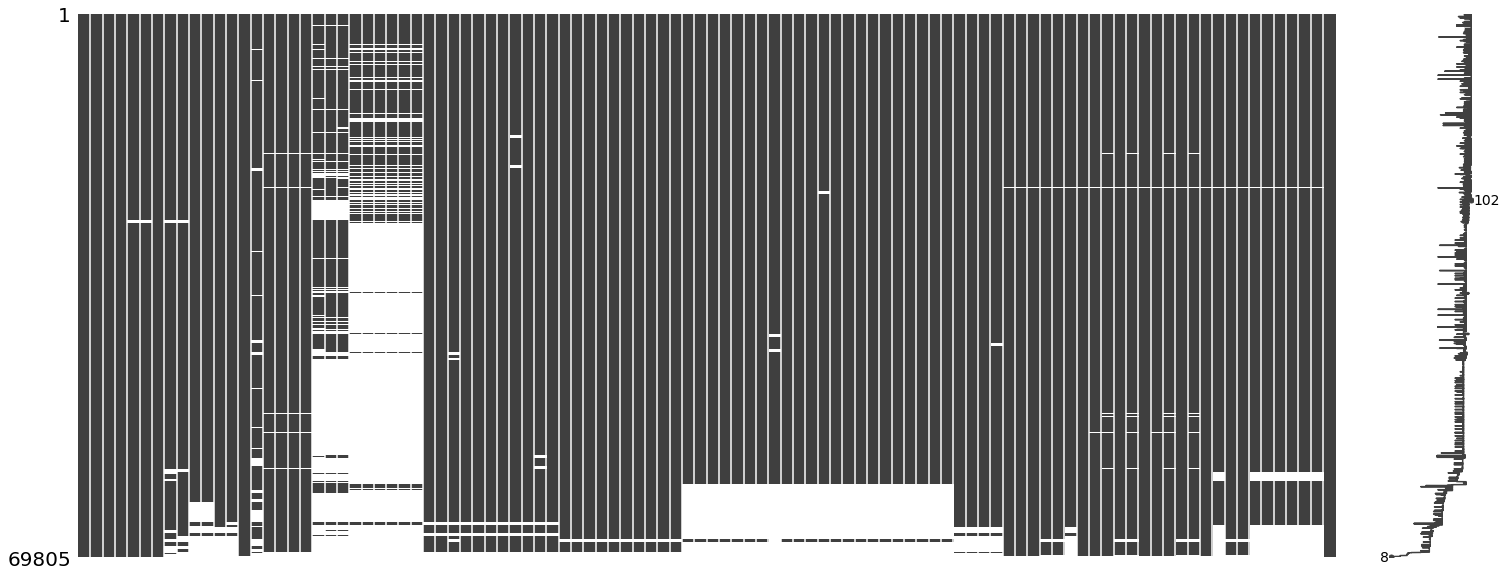

In [ ]:
msno.matrix(country_daily_excess_deaths)

In [ ]:
# TOP NaN countries - by variable
country_daily_excess_deaths[country_daily_excess_deaths.country_rank_by_NaNs<=30].isna().groupby(country_daily_excess_deaths['country.x']).sum()

,iso3c,date,country.x,country_code,region,subregion,population,gdp_per_capita,human_development_index,v2x_libdem,v2x_freexp_altinf,median_age,aged_70_older,life_expectancy,stringency_index,daily_covid_deaths,daily_covid_deaths_per_100k,daily_covid_cases,daily_covid_cases_per_100k,daily_tests,daily_tests_per_100k,daily_positive_rate,daily_total_deaths,daily_total_deaths_per_100k,daily_expected_deaths,daily_expected_deaths_per_100k,daily_excess_deaths,daily_excess_deaths_per_100k,country.y,ccode.x,abbreviation,abbreviation_undp,year.x,democracy,democracy_trans,democracy_breakdowns,democracy_duration,democracy_omitteddata,democracy_femalesuffrage,Country/Territory,...,xrreg,xrcomp,xropen,xconst,parreg,parcomp,exrec,exconst,polcomp,V1,area,area_ifr,iso2c,country.name,econ_section,econ_sub_section,pop.2020,pop.adult,pop.60plus,cases,new_cases,new_cases_7dma,cases.100k.pop,new.cases.100k.pop,deaths,new_deaths,new_deaths_7dma,deaths.100k.pop,new.deaths.100k.pop,cfr,log_gdp_ppp,case_ir,death_r,pred_ir,pred_ir_low,pred_ir_high,pred_cases,pred_cases_low,pred_cases_high,country_rank_by_NaNs
country.x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Austria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,43,38,38,33,33,33,33,33,33,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0
Belgium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,12,7,6,40,40,40,40,40,40,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bulgaria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5,5,5,5,44,41,41,32,32,32,32,32,32,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,0,7,0,1,7,0,7,0,0,0,0,0,0,0,0,0,0,0
Chile,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,50,46,39,24,24,24,24,24,24,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cyprus,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,5,5,5,33,26,26,25,25,25,25,25,25,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,0,7,0,1,7,0,7,0,0,0,0,0,0,0,0,0,0,0
Denmark,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,2,2,2,14,0,2,26,26,26,26,26,26,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,4,0,0,4,0,4,0,0,0,0,0,0,0,0,0,0,0
Estonia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,2,2,2,7,3,3,47,47,47,47,47,47,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,4,0,0,4,0,4,0,0,0,0,0,0,0,0,0,0,0
Finland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,9,4,4,47,47,47,47,47,47,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Hungary,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5,5,5,5,12,9,9,53,53,53,53,53,53,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,0,7,0,1,7,0,7,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Top NaN countries - total NaNs
country_daily_excess_deaths.isna().groupby(country_daily_excess_deaths['country.x']).sum()#.sum(1).sort_values()

,iso3c,date,country.x,country_code,region,subregion,population,gdp_per_capita,human_development_index,v2x_libdem,v2x_freexp_altinf,median_age,aged_70_older,life_expectancy,stringency_index,daily_covid_deaths,daily_covid_deaths_per_100k,daily_covid_cases,daily_covid_cases_per_100k,daily_tests,daily_tests_per_100k,daily_positive_rate,daily_total_deaths,daily_total_deaths_per_100k,daily_expected_deaths,daily_expected_deaths_per_100k,daily_excess_deaths,daily_excess_deaths_per_100k,country.y,ccode.x,abbreviation,abbreviation_undp,year.x,democracy,democracy_trans,democracy_breakdowns,democracy_duration,democracy_omitteddata,democracy_femalesuffrage,Country/Territory,...,xrreg,xrcomp,xropen,xconst,parreg,parcomp,exrec,exconst,polcomp,V1,area,area_ifr,iso2c,country.name,econ_section,econ_sub_section,pop.2020,pop.adult,pop.60plus,cases,new_cases,new_cases_7dma,cases.100k.pop,new.cases.100k.pop,deaths,new_deaths,new_deaths_7dma,deaths.100k.pop,new.deaths.100k.pop,cfr,log_gdp_ppp,case_ir,death_r,pred_ir,pred_ir_low,pred_ir_high,pred_cases,pred_cases_low,pred_cases_high,country_rank_by_NaNs
country.x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,383,383,383,383,383,383,383,383,383,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,13,13,13,13,8,2,13,173,173,173,173,173,173,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,8,8,8,8,8,9,15,8,15,8,9,15,8,15,8,8,8,8,8,8,8,8,8,8,0
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,383,383,383,383,383,383,383,383,383,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0
Andorra,0,0,0,0,0,0,0,382,0,382,382,382,382,0,3,5,5,5,5,317,252,252,382,382,382,382,382,382,0,0,0,0,0,0,0,0,0,0,0,0,...,382,382,382,382,382,382,382,382,382,382,382,382,382,0,0,0,0,0,382,0,1,7,0,7,0,1,7,0,7,0,382,0,0,382,382,382,382,382,382,0
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5,5,5,5,364,364,364,364,364,364,364,364,364,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,0,7,0,1,7,0,7,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5,5,5,5,370,370,370,370,370,370,370,370,370,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,0,7,0,1,7,0,7,0,370,0,0,370,370,370,370,370,370,0
Vietnam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,252,0,0,383,383,383,383,383,383,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Yemen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,5,5,5,5,343,343,343,343,343,343,343,343,343,0,0,0,0,0,0,0,0,0,343,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,0,7,0,1,7,0,7,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Check the difference in terms of # of NaN for the two redundant covid indicator (cases and deaths) -> 
country_daily_excess_deaths.isna().groupby(country_daily_excess_deaths['country.x']).sum()[['new_cases_7dma', "daily_covid_cases", 'new_deaths_7dma', 'daily_covid_deaths']].sum()

new_cases_7dma        1190
daily_covid_cases     1525
new_deaths_7dma       1190
daily_covid_deaths    1525
dtype: int64

In [ ]:
country_daily_excess_deaths.isna().groupby(country_daily_excess_deaths['country.x']).sum()[['new_cases_7dma', "daily_covid_cases", 'new_deaths_7dma', 'daily_covid_deaths']].sum()

new_cases_7dma        1190
daily_covid_cases     1525
new_deaths_7dma       1190
daily_covid_deaths    1525
dtype: int64

In [ ]:
country_daily_excess_deaths['country.x'].groupby(country_daily_excess_deaths['country.x']).count()

country.x
Afghanistan    383
Albania        383
Algeria        383
Andorra        382
Angola         364
              ... 
Venezuela      370
Vietnam        383
Yemen          343
Zambia         366
Zimbabwe       364
Name: country.x, Length: 202, dtype: int64

In [ ]:
filter = country_daily_excess_deaths[country_daily_excess_deaths.country_rank_by_NaNs>=150].isna().groupby(country_daily_excess_deaths['country.x']).sum().sum(1).sort_values().index
filter

Index(['Falkland Islands', 'Macao', 'Turks and Caicos Islands', 'India',
       'Greenland', 'Montserrat', 'Solomon Islands', 'Anguilla', 'Comoros',
       'Saint Helena', 'Sudan', 'Yemen', 'Libya', 'Faeroe Islands',
       'Guinea-Bissau', 'Equatorial Guinea', 'Somalia', 'Isle of Man',
       'Hong Kong', 'Guernsey', 'Jersey', 'Bermuda', 'Vanuatu', 'Samoa',
       'Gibraltar', 'Cuba', 'Venezuela', 'Cayman Islands', 'Syria',
       'Marshall Islands', 'Malta', 'Iceland', 'Maldives',
       'Sao Tome and Principe', 'Barbados', 'Seychelles', 'Belize', 'Bahamas',
       'Grenada', 'Brunei', 'Saint Lucia', 'Saint Vincent and the Grenadines',
       'Antigua and Barbuda', 'Serbia', 'Dominica', 'Saint Kitts and Nevis',
       'Palestine', 'Andorra', 'Vatican', 'San Marino', 'Liechtenstein',
       'Monaco'],
      dtype='object', name='country.x')

In [ ]:
country_daily_excess_deaths[country_daily_excess_deaths.country_rank_by_NaNs>=150].isna().groupby(country_daily_excess_deaths['country.x']).sum().sum(1)

In [ ]:
rank_by_nan = (country_daily_excess_deaths[country_daily_excess_deaths.country_rank_by_NaNs>=150].isna().groupby(country_daily_excess_deaths['country.x']).sum().sum(1) / 
               country_daily_excess_deaths[country_daily_excess_deaths['country.x'].isin(filter)]['country.x'].groupby(country_daily_excess_deaths['country.x']).count()).sort_values(ascending=True)*100
selected_countries = rank_by_nan[rank_by_nan<=10].index
len((selected_countries))

0

In [ ]:
country_daily_excess_deaths_selected = country_daily_excess_deaths[country_daily_excess_deaths['country.x'].isin(selected_countries)]

In [ ]:
country_daily_excess_deaths_selected

,iso3c,date,country.x,country_code,region,subregion,population,gdp_per_capita,human_development_index,v2x_libdem,v2x_freexp_altinf,median_age,aged_70_older,life_expectancy,stringency_index,daily_covid_deaths,daily_covid_deaths_per_100k,daily_covid_cases,daily_covid_cases_per_100k,daily_tests,daily_tests_per_100k,daily_positive_rate,daily_total_deaths,daily_total_deaths_per_100k,daily_expected_deaths,daily_expected_deaths_per_100k,daily_excess_deaths,daily_excess_deaths_per_100k,country.y,ccode.x,abbreviation,abbreviation_undp,year.x,democracy,democracy_trans,democracy_breakdowns,democracy_duration,democracy_omitteddata,democracy_femalesuffrage,Country/Territory,...,xrreg,xrcomp,xropen,xconst,parreg,parcomp,exrec,exconst,polcomp,V1,area,area_ifr,iso2c,country.name,econ_section,econ_sub_section,pop.2020,pop.adult,pop.60plus,cases,new_cases,new_cases_7dma,cases.100k.pop,new.cases.100k.pop,deaths,new_deaths,new_deaths_7dma,deaths.100k.pop,new.deaths.100k.pop,cfr,log_gdp_ppp,case_ir,death_r,pred_ir,pred_ir_low,pred_ir_high,pred_cases,pred_cases_low,pred_cases_high,country_rank_by_NaNs


In [ ]:
# Fill in missing values for selected countries
for i in country_daily_excess_death_selected.columns:
  country_daily_excess_death_selected[i] = country_daily_excess_death_selected[i].fillna(country_daily_excess_death_selected.groupby('iso3c')[i].transform('ffill'))

for i in country_daily_excess_death_selected.columns:
  country_daily_excess_death_selected[i] = country_daily_excess_death_selected[i].fillna(country_daily_excess_death_selected.groupby('iso3c')[i].transform('bfill'))

In [ ]:
country_daily_excess_death_selected.drop('country_rank_by_NaNs',1, inplace=True)

In [ ]:
msno.matrix(country_daily_excess_death_selected)

In [ ]:
# tests, positivty rate, vaccine related data is full of missing values

In [ ]:
country_daily_excess_death_selected.groupby('iso3c').mean()

In [ ]:
country_daily_excess_death_selected['iso3c'].unique()